# CRpropa simulation

Set up a 3D simulation with energy losses to mimic the case used in the generative model to test the arrival direction and joint models. To install CRPropa, see the info [here](https://github.com/CRPropa/CRPropa3).
<br>
<br>
Summary of the assumptions:
* Only protons
* Random turbulent B field with $B_\rm{RMS} = B \ \rm{nG}$
<br>
<br>

In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt

# Testing
import sys
sys.path.append('/Users/fran/.virtualenvs/crpropa/CRPropa3/build')
from crpropa import *

# Testing
sys.path.append('../../../../fancy')
from fancy.interfaces.stan import Direction 
from fancy.plotting import AllSkyMap
from fancy import Data, Model, Analysis, Results
from fancy.detector.auger2014 import detector_properties
from fancy.propagation.energy_loss import get_source_threshold_energy

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/fran/projects/bayes/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Data
Read in the same data and output of the generative model simulation.

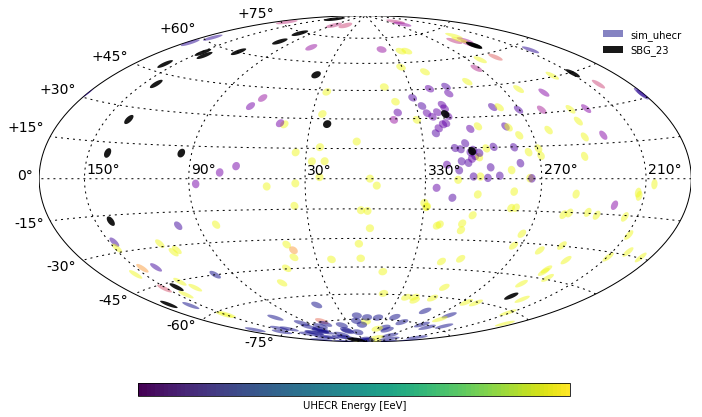

In [2]:
# Read in relevant data
sim_output_file = '../arrival_vs_joint/output/joint_model_simulation.h5'

data = Data()
data.from_file(sim_output_file)
data.show()

# Other useful info
with h5py.File(sim_output_file, 'r') as f:
    source_labels = f['uhecr/source_labels'].value
    Eth = f['model/Eth'].value
    Eth_sim = f['model/Eth_sim'].value
    alpha = f['model/alpha'].value
    B = f['model/B'].value
    f_E = f['detector/f_E'].value

In [10]:
# Get source vectors for CRPropa
source_vectors = []
for i, uv in enumerate(data.source.unit_vector):
    # add 0.5 to counter detection effects
    v = Vector3d(uv[0], uv[1], uv[2]) * (data.source.distance[i] + 0.5) 
    source_vectors.append(v)

In [11]:
# Define desired number of source events and save background events
lambda0 = data.source.N
Nbg = list(source_labels).count(lambda0)
Nsrc = data.uhecr.N - Nbg

bg_i = np.where(source_labels == lambda0)
Edet_bg = data.uhecr.energy[bg_i]
uv_bg = data.uhecr.unit_vector[bg_i]

## Magnetic field model

In [9]:
random_seed = 42
l_c = 1 # Mpc
n = 500
spacing = 100 # kpc
Lmin = 1000 # kpc
Lmax = 3135 # kpc

vgrid = VectorGrid(Vector3d(0), n, spacing * kpc)
initTurbulence(vgrid, B * nG, Lmin * kpc, Lmax * kpc, -11.0 / 3.0, random_seed)
Bfield = MagneticFieldGrid(vgrid)

# Print B field propertie
# print some properties of our field
print ('Lc = %.1f kpc' % turbulentCorrelationLength(Lmin, Lmax, -11/3.)) 
print ('<B^2> = %.1f nG' % (rmsFieldStrength(vgrid) / nG))   # RMS
print ('<|B|> = %.1f nG' % (meanFieldStrength(vgrid) / nG))  # mean
print ('B(10 Mpc, 0, 0) =', Bfield.getField(Vector3d(10,0,0) * Mpc) / nG, 'nG')
print('size:', n*spacing / 1e3, 'Mpc')

Lc = 1000.9 kpc
<B^2> = 20.0 nG
<|B|> = 18.4 nG
B(10 Mpc, 0, 0) = Vector(-0.175969, 0.0143479, 0.162225) nG
size: 50.0 Mpc


In [12]:
# check Lc with Harari et al. (2002) calculation
def Lc(Lmin, Lmax, n):
    return 0.5 * Lmax * ((n-1) / n) * ((1 - (Lmin/Lmax)**n) / (1 - (Lmin/Lmax)**(n-1)))

print ('Lc (CRPropa) = %.1f kpc' % turbulentCorrelationLength(Lmin, Lmax, -11/3.)) 
print('Lc (Harari et al.) = %.1f kpc' % Lc(1000, 3135, 5./3.))

Lc (CRPropa) = 1000.9 kpc
Lc (Harari et al.) = 1000.9 kpc


## Sources

In [13]:
sources = []
for i, v in enumerate(source_vectors):
    s = Source()
    s.add( SourcePosition((v) * Mpc) )
    s.add( SourceParticleType(nucleusId(1, 1)) )
    s.add( SourcePowerLawSpectrum(Eth_sim * EeV, 1e4 * EeV, -alpha) )
    s.add( SourceIsotropicEmission() )
    sources.append(s)

source_list = SourceList()
Ns = len(sources)
for s in sources:
    source_list.add(s, (1 / Ns))

## Simulation

In [14]:
sim = ModuleList()
sim.add( PropagationCK(Bfield) )
sim.add( PhotoPionProduction(CMB) )
sim.add( PhotoPionProduction(IRB) )
sim.add( PhotoDisintegration(CMB) )
sim.add( PhotoDisintegration(IRB) )
sim.add( ElectronPairProduction(CMB) )
sim.add( ElectronPairProduction(IRB) )
sim.add( NuclearDecay() )
sim.add( MinimumEnergy( Eth_sim * EeV) )

# Observer
obs = Observer()
obs.add( ObserverSurface( Sphere(Vector3d(0, 0, 0,), 0.5 * Mpc)) )
sim.add(obs)

# Event output
output = TextOutput('output/crpropa_events.txt', Output.Event3D)
obs.onDetection(output)

In [21]:
# Run

#N = 5000000 # for paper
N = 100000 # for testing

sim.setShowProgress(True)  
sim.run(source_list, N)
output.close()

### Visualise simulation output

In [12]:
# Spectrum
np.random.seed(5)

output_data = np.genfromtxt('output/paper_crpropa_events.txt', names = True)
N_event = len(output_data)
print ('Number of events:', N_event)

E = output_data['E0']
Earr = output_data['E']

# Detection effects
Edet = np.array([np.random.normal(e, e * f_E) for e in Earr])
ind_cut = np.where(Edet > Eth)[0]
Edet = Edet[ind_cut]
print('Number above events above energy threshold:', len(ind_cut))

bins = np.logspace(np.log(min(E)), np.log(max(E)), base = np.e)

Number of events: 11659
Number above events above energy threshold: 941


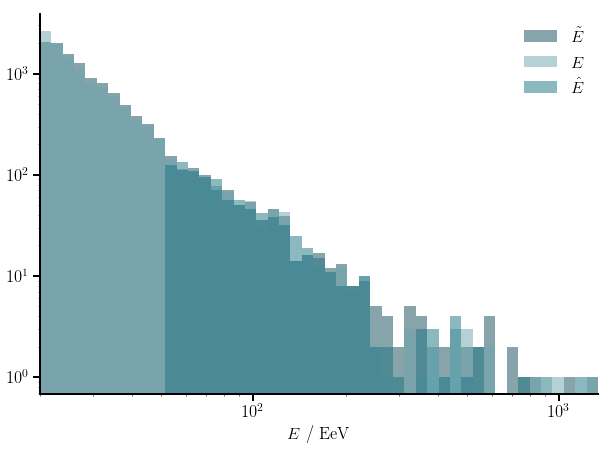

In [13]:
plt.style.use(['minimalist', 'blues'])

# Plot the spectrum
fig, ax = plt.subplots()
fig.set_size_inches((10, 7))
ax.hist(E, bins = bins, alpha = 0.5, label = r'$\tilde{E}$')
ax.hist(Earr, bins = bins, alpha = 0.5, label = '$E$')
ax.hist(Edet, bins = bins, alpha = 0.5, label = '$\hat{E}$')
ax.set_xlabel('$E$ / EeV')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend();

In [14]:
# Arrival directions
unit_vector = []
Px = output_data['Px'][ind_cut]
Py = output_data['Py'][ind_cut]
Pz = output_data['Pz'][ind_cut]

for i in range(len(Px)):
    unit_vector.append([-Px[i], 
                        -Py[i], 
                        -Pz[i]])
arr_dir = Direction(unit_vector)
source_dir = Direction(data.source.unit_vector) 

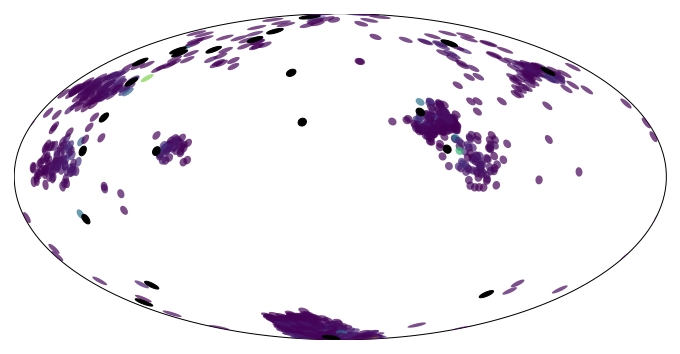

In [15]:
from matplotlib.colors import Normalize

fig, ax = plt.subplots()
fig.set_size_inches((12, 6))
skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0)

norm_E = Normalize(min(Edet), max(Edet))
cmap = plt.cm.get_cmap('viridis')
    
for e, lon, lat in np.nditer([Edet, arr_dir.lons, arr_dir.lats]):
    color = cmap(norm_E(e))
    skymap.tissot(lon, lat, 2.0, 30, alpha = 0.7, facecolor = color)
for lon, lat in np.nditer([source_dir.lons, source_dir.lats]):
    skymap.tissot(lon, lat, 2.0, 30, color = 'k', alpha = 1)

### Detector exposure effects

Now add in the effect of the Pierre Auger Observatory exposure, as was done in the Stan simulation.

In [16]:
from fancy.detector.exposure import m
from fancy.detector.auger2014 import auger_params, kappa_d
from vMF import sample_vMF

In [17]:
# Exposure
m_max = m(np.pi, auger_params)
theta = [np.arccos(uv[2]) for uv in arr_dir.unit_vector]
selection = []
for i, t in enumerate(theta):
    pdet = m(t, auger_params) / m_max
    accept = np.random.choice([0, 1], p = [pdet, 1 - pdet])
    if accept == 0:
        selection.append(i)

arr_dir_uv = [arr_dir.unit_vector[i] for i in selection]
Edet = [Edet[i] for i in selection]        
print(len(selection), 'UHECR detected')

# Reconstruction uncertainty
arr_dir_uv = [sample_vMF(np.array(ad), kappa_d, 1)[0] for ad in arr_dir_uv]

# Make proper unit vectors
arr_dir_uv = [a / np.linalg.norm(a) for a in arr_dir_uv]

372 UHECR detected


In [18]:
# Randomly select Nsrc source events to match generative model simulation
Ndet = len(selection)
inds = np.random.choice(Ndet, Nsrc) 
Edet = [Edet[i] for i in inds]
arr_dir_uv = [arr_dir_uv[i] for i in inds]

# Add background from generative model simulaiton
total_Edet = list(Edet) + list(Edet_bg)
total_arr_dir_uv = list(arr_dir_uv) + list(uv_bg)
total_arr_dir = Direction(total_arr_dir_uv)
print('Total # of UHECRs:', len(total_Edet))

Total # of UHECRs: 249


### Visualise final CRPropa data set 

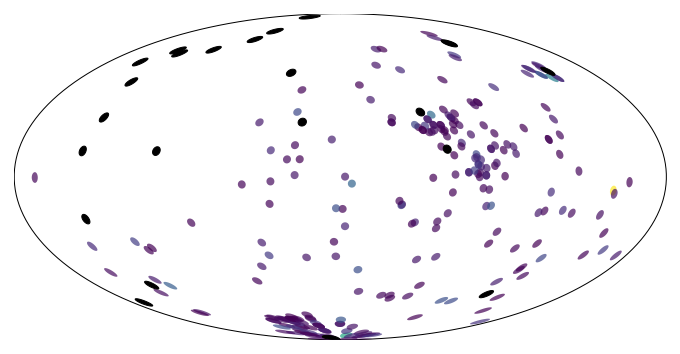

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches((12, 6))
skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0)

norm_E = Normalize(min(total_Edet), max(total_Edet))
cmap = plt.cm.get_cmap('viridis')

for e, lon, lat in np.nditer([total_Edet, total_arr_dir.lons, total_arr_dir.lats]):
    color = cmap(norm_E(e))
    skymap.tissot(lon, lat, 2.0, 30, alpha = 0.7, facecolor = color)
for lon, lat in np.nditer([source_dir.lons, source_dir.lats]):
    skymap.tissot(lon, lat, 2.0, 30, color = 'k', alpha = 1)

### Save to file

In [22]:
crpropa_sim_output = 'output/crpropa_sim.h5'

with h5py.File(crpropa_sim_output, 'w') as f:
    uhecr = f.create_group('uhecr')
    uhecr.create_dataset('energy', data = total_Edet)
    uhecr.create_dataset('unit_vector', data = total_arr_dir_uv)